# StellarGraph Ensemble for link prediction

In this example, we use `stellargraph`'s `Ensemble` class of [GraphSAGE](http://snap.stanford.edu/graphsage/) models to predict citation links in the Cora dataset (see below). The `Ensemble` class brings ensemble learning to `stellargraph`'s graph neural network models, e.g., `GraphSAGE`, quantifying prediction variance and potentially improving prediction accuracy. 

The problem is treated as a supervised link prediction problem on a homogeneous citation network with nodes representing papers (with attributes such as binary keyword indicators and categorical subject) and links corresponding to paper-paper citations. 

To address this problem, we build a base `GraphSAGE` model with the following architecture. First we build a two-layer GraphSAGE model that takes labeled `citing-paper` -> `cited-paper` node pairs corresponding to possible citation links, and outputs a pair of node embeddings for the `cited-paper` and `citing-paper` nodes of the pair. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. Thus obtained, link embeddings are passed through the dense link classification layer to obtain link predictions - the probability for these candidate links to actually exist in the network. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false citation links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model.

Finally, using our base model, we create an ensemble with each model in the ensemble trained on a bootstrapped sample of the training data. 

**References**

1. Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216 
[cs.SI], 2017.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import keras 
import os

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph import Ensemble

from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar

%matplotlib inline

Using TensorFlow backend.


In [2]:
def plot_history(history):
    def remove_prefix(text, prefix):
        return text[text.startswith(prefix) and len(prefix):]

    figsize=(7, 5)
    c_train = 'b'
    c_test = 'g'
    
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history[0].history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.figure(figsize=figsize)
        for h in history:
            plt.plot(h.history[m], c=c_train)
            plt.plot(h.history['val_' + m], c=c_test)
            
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

In [3]:
def load_cora(data_dir, largest_cc=False):
    # load directed graph from ordering (cited_paper, citing_paper)
    data_path = os.path.expanduser(os.path.join(data_dir, "cora.cites"))
    g_nx = nx.read_edgelist(path=data_path, create_using=nx.DiGraph()).reverse()
    
    for edge in g_nx.edges(data=True):
        edge[2]['label'] = 'cites'

    # convert to undirected graph for processing
    g_nx = g_nx.to_undirected()
    
    # load the node attribute data
    cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
    node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)
    values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
    nx.set_node_attributes(g_nx, values, 'subject')

    if largest_cc:
        # Select the largest connected component. For clarity we ignore isolated
        # nodes and subgraphs; having these in the data does not prevent the
        # algorithm from running and producing valid results.
        g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
        g_nx = max(g_nx_ccs, key=len)
        print("Largest subgraph statistics: {} nodes, {} edges".format(
            g_nx.number_of_nodes(), g_nx.number_of_edges()))
    
    feature_names = ["w_{}".format(ii) for ii in range(1433)]
    column_names =  feature_names + ["subject"]
    node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)
    
    node_data.index = node_data.index.map(str)
    node_data = node_data[node_data.index.isin(list(g_nx.nodes()))]

    return g_nx, node_data, feature_names

### Loading the CORA network data

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [4]:
data_dir = os.path.expanduser("~/data/cora")

Load the dataset

In [5]:
G, node_data, feature_names = load_cora(data_dir)

We need to convert node features that will be used by the model to numeric values that are required for GraphSAGE input. Note that all node features in the Cora dataset, except the categorical "subject" feature, are already numeric, and don't require the conversion.

In [6]:
if "subject" in feature_names:
    # Convert node features to numeric vectors
    feature_encoding = feature_extraction.DictVectorizer(sparse=False)
    node_features = feature_encoding.fit_transform(
        node_data[feature_names].to_dict("records")
    )
else:  # node features are already numeric, no further conversion is needed
    node_features = node_data[feature_names].values

Add node data to G:

In [7]:
for nid, f in zip(node_data.index, node_features):
    G.node[nid][globalvar.TYPE_ATTR_NAME] = "paper"  # specify node type
    G.node[nid]["feature"] = f

We aim to train a link prediction model, hence we need to prepare the train and test sets of links and the corresponding graphs with those links removed.

We are going to split our input graph into train and test graphs using the `EdgeSplitter` class in `stellargraph.data`. We will use the train graph for training the model (a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not) and the test graph for evaluating the model's performance on hold out data.

Each of these graphs will have the same number of nodes as the input graph, but the number of links will differ (be reduced) as some of the links will be removed during each split and used as the positive samples for training/testing the link prediction classifier.

From the original graph G, extract a randomly sampled subset of test edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [8]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42
)

** Sampled 527 positive and 527 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Now, repeat this procedure to obtain validation data that we are going to use for early stopping in order to prevent overfitting. From the reduced graph G_test, extract a randomly sampled subset of validation edges (true and false citation links) and the reduced graph G_val with the positive validation edges removed.

In [9]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_val = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, 
# and obtain the reduced graph G_train with the sampled links removed:
G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=100
)

** Sampled 475 positive and 475 negative edges. **


We repeat this procedure one last time in order to obtain the training data for the model.
From the reduced graph G_val, extract a randomly sampled subset of train edges (true and false citation links) and the reduced graph G_train with the positive train edges removed:

In [10]:
# Define an edge splitter on the reduced graph G_val:
edge_splitter_train = EdgeSplitter(G_val)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_val, 
# and obtain the reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42
)

** Sampled 427 positive and 427 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Convert G_train, G_val, and G_test to StellarGraph objects (undirected, as required by GraphSAGE) for ML:

In [11]:
G_train = sg.StellarGraph(G_train, node_features="feature")
G_test = sg.StellarGraph(G_test, node_features="feature")
G_val = sg.StellarGraph(G_val, node_features="feature")

Summary of G_train, G_val and G_test - note that they have the same set of nodes, only differing in their edge sets:

In [12]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 3849

 Node types:
  paper: [2708]
        Attributes: {'subject', 'feature'}
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [3849]



In [13]:
print(G_val.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4276

 Node types:
  paper: [2708]
        Attributes: {'subject', 'feature'}
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4276]



In [14]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4751

 Node types:
  paper: [2708]
        Attributes: {'subject', 'feature'}
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4751]



### Specify global parameters

Here we specify some important parameters that control the type of ensemble model we are going to use. For example, we specify the number of models in the ensemble and the number of predictions per query point per model.

In [15]:
n_estimators = 5    # Number of models in the ensemble
n_predictions = 10  # Number of predictions per query point per model

Next, we create link generators for sampling and streaming train and test link examples to the model. The link generators essentially "map" pairs of nodes `(citing-paper, cited-paper)` to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with `(citing-paper, cited-paper)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [16]:
batch_size = 20
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE. Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model:

In [17]:
num_samples = [20, 10]

### Create the generators for training

For training we create a generator on the `G_train` graph. The `shuffle=True` argument is given to the `flow` method to improve training.

In [18]:
generator = GraphSAGELinkGenerator(G_train, batch_size, num_samples) 

In [19]:
train_gen = generator.flow(edge_ids_train, 
                           edge_labels_train, 
                           shuffle=True)

At test time we use the `G_test` graph and don't specify the `shuffle` argument (it defaults to `False`).

In [20]:
test_gen = GraphSAGELinkGenerator(G_test,  batch_size, num_samples).flow(edge_ids_test, 
                                                                         edge_labels_test)

In [21]:
val_gen = GraphSAGELinkGenerator(G_val,  batch_size, num_samples).flow(edge_ids_val, 
                                                                       edge_labels_val)

### Create the base GraphSAGE model

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated (`citing-paper`, `cited-paper`) node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 20 for both GraphSAGE layers, a bias term, and average dropout. (Dropout can be switched off by specifying a zero dropout rate)

Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [22]:
layer_sizes = [20, 20]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.5
)

In [23]:
x_inp, x_out = graphsage.build()

Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [24]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method='ip'
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model.

In [25]:
base_model = keras.Model(inputs=x_inp, outputs=prediction)

Now we create the ensemble based on `base_model` we just created.

In [26]:
model = Ensemble(model=base_model, n_estimators=n_estimators, n_predictions=n_predictions)

We need to `compile` the model specifying the optimiser, loss function, and metrics to use.

In [27]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    weighted_metrics=["acc"],
)

Evaluate the initial (untrained) ensemble of models on the train and test set:

In [28]:
init_train_metrics_mean, init_train_metrics_std = model.evaluate_generator(train_gen)
init_test_metrics_mean, init_test_metrics_std = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, m, s in zip(model.metrics_names, init_train_metrics_mean, init_train_metrics_std):
    print("\t{}: {:0.4f}±{:0.4f}".format(name, m, s))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, m, s in zip(model.metrics_names, init_test_metrics_mean, init_test_metrics_std):
    print("\t{}: {:0.4f}±{:0.4f}".format(name, m, s))


Train Set Metrics of the initial (untrained) model:
	loss: 0.7582±0.0995
	weighted_acc: 0.6085±0.0236

Test Set Metrics of the initial (untrained) model:
	loss: 0.7185±0.0593
	weighted_acc: 0.6098±0.0146


### Train the ensemble model

We are going to use **bootstrap samples** of the training dataset to train each model in the ensemble. For this purpose, we need to pass `generator`, `edge_ids_train`, and `edge_labels_train` to the `fit_generator` method.

Note that training time will vary based on computer speed. Set `verbose=1` for reporting of training progress.

In [29]:
history = model.fit_generator(
    generator=generator,
    train_data = edge_ids_train,
    train_targets = edge_labels_train,
    epochs=epochs,
    validation_generator=val_gen,
    verbose=0,
    use_early_stopping=True,  # Enable early stopping
    early_stopping_monitor="val_weighted_acc",
)

Plot the training history:

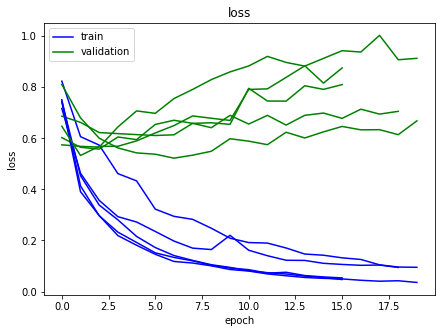

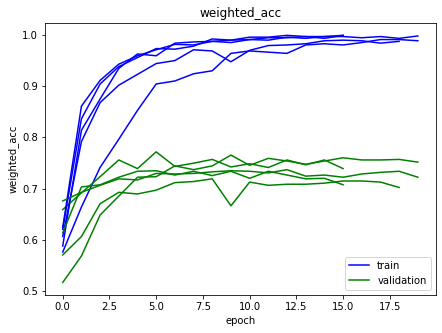

In [30]:
plot_history(history)

Evaluate the trained model on test citation links. After training the model, performance should be better than before training (shown above):

In [31]:
train_metrics_mean, train_metrics_std = model.evaluate_generator(train_gen)
test_metrics_mean, test_metrics_std = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, m, s in zip(model.metrics_names, train_metrics_mean, train_metrics_std):
    print("\t{}: {:0.4f}±{:0.4f}".format(name, m, s))

print("\nTest Set Metrics of the trained model:")
for name, m, s in zip(model.metrics_names, test_metrics_mean, test_metrics_std):
    print("\t{}: {:0.4f}±{:0.4f}".format(name, m, s))


Train Set Metrics of the trained model:
	loss: 0.2868±0.0135
	weighted_acc: 0.8926±0.0056

Test Set Metrics of the trained model:
	loss: 0.5358±0.0948
	weighted_acc: 0.7649±0.0182


### Make predictions with the model

Now let's get the predictions for all the edges in the test set.

In [32]:
test_predictions = model.predict_generator(generator=test_gen)

These predictions will be the output of the last layer in the model with `sigmoid` activation.

The array `test_predictions` has dimensionality $M\times K\times N\times F$ where $M$ is the number of estimators in the ensemble (`n_estimators`); $K$ is the number of predictions per query point per estimator (`n_predictions`); $N$ is the number of query points (`len(test_predictions)`); and $F$ is the output dimensionality of the specified layer determined by the shape of the output layer (in this case it is equal to 1 since we are performing binary classification).

In [33]:
type(test_predictions), test_predictions.shape

(numpy.ndarray, (5, 10, 1054, 1))

For demonstration, we are going to select one of the edges in the test set, and plot the ensemble's predictions for that edge.

Change the value of `selected_query_point` (valid values are in the range of `0` to `len(test_predictions) - 1`) to visualise the results for another test point.

In [34]:
selected_query_point = -10

In [35]:
# Select the predictios for the point specified by selected_query_point
qp_predictions = test_predictions[:, :, selected_query_point, :]
# The shape should be n_estimators x n_predictions x size_output_layer
qp_predictions.shape

(5, 10, 1)

Next, to facilitate plotting the predictions using either a density plot or a box plot, we are going to reshape `qp_predictions` to $R\times F$ where $R$ is equal to $M\times K$ as above and $F$ is the output dimensionality of the output layer.

In [36]:
qp_predictions = qp_predictions.reshape(np.product(qp_predictions.shape[0:-1]), 
                                        qp_predictions.shape[-1])
qp_predictions.shape

(50, 1)

The model returns the probability of edge, the class to predict. The probability of no edge is just the complement of the latter. Let's calculate it so that we can plot the distribution of predictions for both outcomes.

In [37]:
qp_predictions=np.hstack((qp_predictions, 1.-qp_predictions,))

We'd like to assess the ensemble's confidence in its predictions in order to decide if we can trust them or not. Utilising a box plot, we can visually inspect the ensemble's distribution of prediction probabilities for a point in the test set.

If the spread of values for the predicted point class is well separated from those of the other class with little overlap then we can be confident that the prediction is correct.

Text(0.5, 0, 'Class')

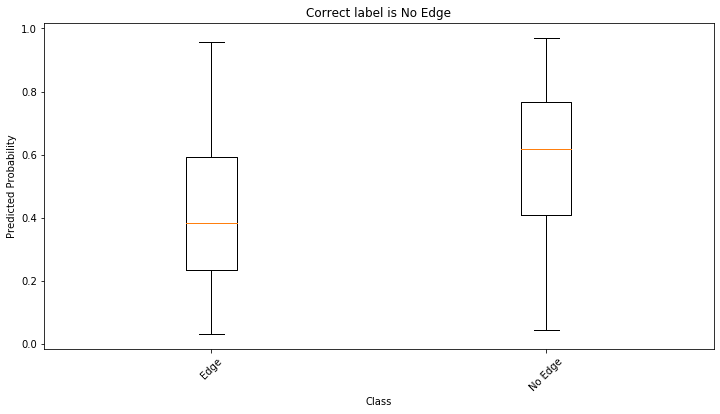

In [38]:
correct_label = "Edge"
if edge_labels_test[selected_query_point] == 0:
    correct_label = "No Edge"

fig, ax = plt.subplots(figsize=(12,6))
ax.boxplot(x=qp_predictions)
ax.set_xticklabels(["Edge", "No Edge"])
ax.tick_params(axis='x', rotation=45)
plt.title("Correct label is "+ correct_label)
plt.ylabel("Predicted Probability")
plt.xlabel("Class")

For the selected pair of nodes (query point), the ensemble is not certain as to whether an edge between these two nodes should exist. This can be inferred by the large spread of values as indicated in the above figure.

(Note that due to the stochastic nature of training neural network algorithms, the above conclusion may not be valid if you re-run the notebook; however, the general conclusion that the use of ensemble learning can be used to quantify the model's uncertainty about its prediction still holds.)

The below image shows an example of the classifier making a correct prediction with higher confidence than the above example. The results is for the setting `selected_query_point=0`.

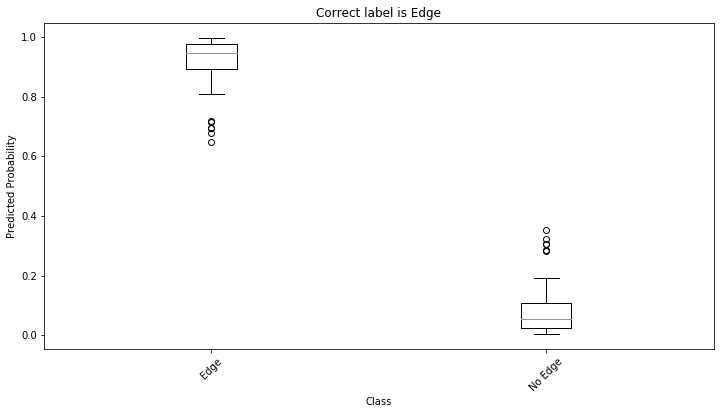